# Kaggle Competition: Store Sales - Time Series Forecasting
Predicting Corporación Favorita`s sales, a large Ecuadorian-based grocery retailer, applying machine learning

#### Importing libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Kaggle API Key
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/KaggleKey/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # Downloading and unziping the dataset
! kaggle competitions download -c store-sales-time-series-forecasting
! unzip -qq /content/store-sales-time-series-forecasting.zip
print('Files ready!')

 51% 11.0M/21.4M [00:00<00:00, 114MB/s]
100% 21.4M/21.4M [00:00<00:00, 166MB/s]
Files ready!


In [ ]:
# ! pip install -q https://github.com/ydataai/pandas-profiling/archive/master.zip
# print('import ready')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from fastai.tabular.all import add_datepart

# from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error

from xgboost import XGBRegressor

In [ ]:
train = pd.read_csv('/content/train.csv')
train['date'] = pd.to_datetime(train['date'])
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
print('Train dataset shape:', train.shape)
print('Columns:', train.columns)
print('Data Types:', train.dtypes)

Train dataset shape: (3000888, 6)
Columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Data Types: id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object


In [ ]:
# report = ProfileReport(train, title='Dataset Report', minimal=True)
# report.to_notebook_iframe()

#### Test Dataset

In [ ]:
to_predict = pd.read_csv('/content/test.csv')
to_predict['date'] = pd.to_datetime(to_predict['date'])
to_predict

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


### Splitting the train dataset into train and validation

In [ ]:
n = int(round(train.shape[0] * 0.7, 0))
n2 = int(round(train.shape[0] * 0.9, 0))
train_ds = train.iloc[:n]
valid_ds = train.iloc[n:n2]
test_ds = train.iloc[n2:]

In [ ]:
train_ds

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
2100617,2100617,2016-03-27,49,BEAUTY,10.000,0
2100618,2100618,2016-03-27,49,BEVERAGES,8885.000,4
2100619,2100619,2016-03-27,49,BOOKS,0.000,0
2100620,2100620,2016-03-27,49,BREAD/BAKERY,1374.956,2


In [ ]:
valid_ds

,id,date,store_nbr,family,sales,onpromotion
2100622,2100622,2016-03-27,49,CLEANING,1977.000,26
2100623,2100623,2016-03-27,49,DAIRY,3036.000,0
2100624,2100624,2016-03-27,49,DELI,519.661,0
2100625,2100625,2016-03-27,49,EGGS,583.000,0
2100626,2100626,2016-03-27,49,FROZEN FOODS,415.086,0
...,...,...,...,...,...,...
2700794,2700794,2017-02-28,39,DAIRY,735.000,15
2700795,2700795,2017-02-28,39,DELI,240.792,7
2700796,2700796,2017-02-28,39,EGGS,408.000,1
2700797,2700797,2017-02-28,39,FROZEN FOODS,72.000,4


In [ ]:
test_ds

,id,date,store_nbr,family,sales,onpromotion
2700799,2700799,2017-02-28,39,GROCERY II,23.000,1
2700800,2700800,2017-02-28,39,HARDWARE,3.000,0
2700801,2700801,2017-02-28,39,HOME AND KITCHEN I,168.000,2
2700802,2700802,2017-02-28,39,HOME AND KITCHEN II,21.000,2
2700803,2700803,2017-02-28,39,HOME APPLIANCES,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


### Data Exploration

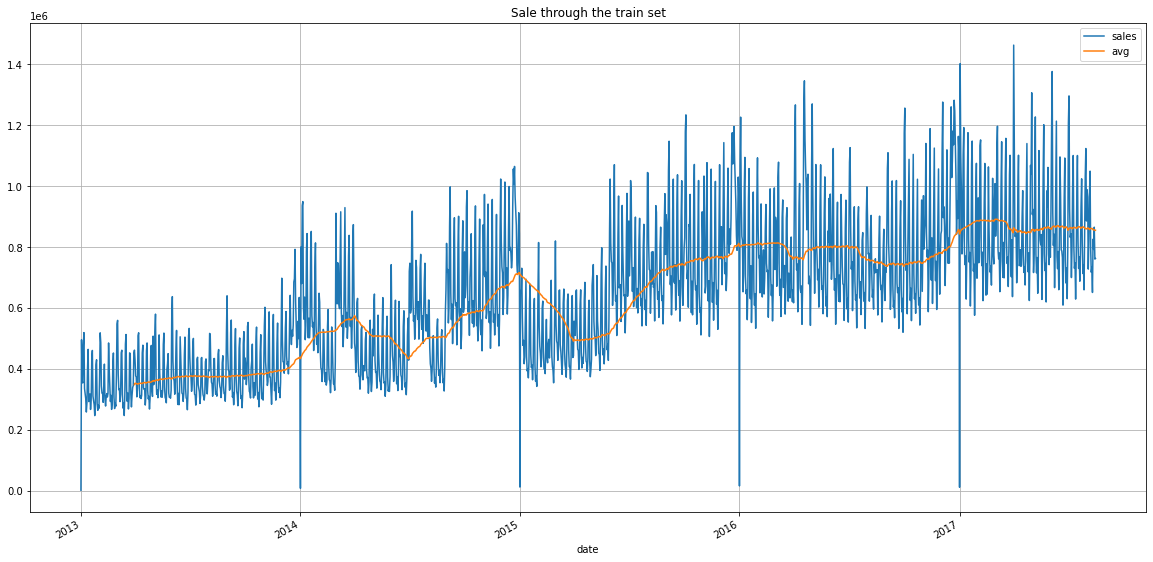

In [ ]:
sales_per_day = train.groupby(by='date').sales.sum()
sales_per_day = pd.DataFrame(data=sales_per_day)
sales_per_day['avg'] = sales_per_day.sales.rolling(90).mean()
sales_per_day.plot(figsize=(20,10), title='Sale through the train set', grid=True)

In [ ]:
sales_per_day[sales_per_day['sales'] < 0.2e6]

,sales,avg
date,,
2013-01-01,2511.618999,NaN
2014-01-01,8602.065404,434366.690864
2015-01-01,12773.616980,709579.530285
2016-01-01,16433.394000,803517.509487
2017-01-01,12082.500997,843265.402943


This show us how important are holidays in the amount of sales that the stores make.

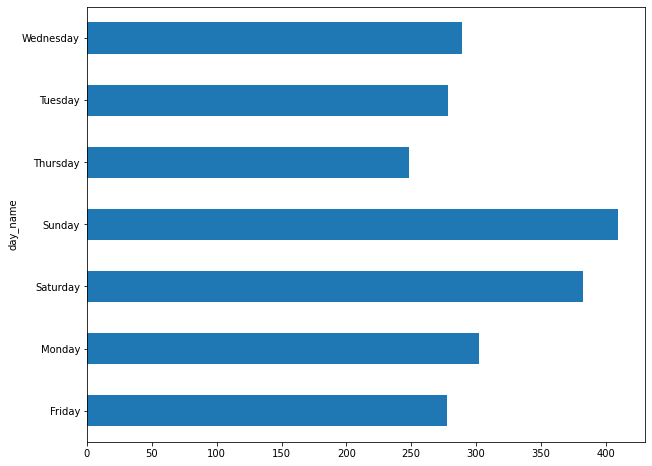

In [ ]:
by_day_name = train_ds.copy()
by_day_name['day_name'] = train_ds['date'].dt.day_name()
by_day_name = by_day_name.groupby(by='day_name').sales.mean()
by_day_name.plot(kind='barh', figsize=(10, 8))

In [ ]:
transactions = pd.read_csv('/content/transactions.csv', date_parser='date')
print(transactions.shape)
transactions

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [ ]:
oil = pd.read_csv('/content/oil.csv', date_parser='date')
print(oil.shape)
oil

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [ ]:
holidays = pd.read_csv('/content/holidays_events.csv')
print(holidays.shape)
holidays

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


## Preprocessing the main dataset

In [ ]:
train_ds

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
2100617,2100617,2016-03-27,49,BEAUTY,10.000,0
2100618,2100618,2016-03-27,49,BEVERAGES,8885.000,4
2100619,2100619,2016-03-27,49,BOOKS,0.000,0
2100620,2100620,2016-03-27,49,BREAD/BAKERY,1374.956,2


In [ ]:
train_datepart = train_ds.copy()
train_datepart = add_datepart(train_datepart, 'date')
valid_datepart = valid_ds.copy()
valid_datepart = add_datepart(valid_datepart, 'date')

In [ ]:
y_train = train_datepart['sales']
X_train = train_datepart.drop(['id', 'sales'], axis=1)

y_valid = valid_datepart['sales']
X_valid = valid_datepart.drop(['id', 'sales'], axis=1)

In [ ]:
def add_date_and_drop(df, indep=False):
  df_cp = df.copy()
  df_cp = add_datepart(df_cp, 'date')
  y = None
  if indep:
    y = df_cp['sales']
    df_cp = df_cp.drop(['id', 'sales'], axis=1)
  else:
    y = df_cp['id']
    df_cp = df_cp.drop('id', axis=1)
  return df_cp, y


In [ ]:
X_train.family.value_counts()

AUTOMOTIVE                    63656
BEAUTY                        63656
BEVERAGES                     63656
BOOKS                         63656
BREAD/BAKERY                  63656
CELEBRATION                   63656
BABY CARE                     63656
PET SUPPLIES                  63655
LIQUOR,WINE,BEER              63655
MAGAZINES                     63655
MEATS                         63655
PERSONAL CARE                 63655
PREPARED FOODS                63655
PLAYERS AND ELECTRONICS       63655
POULTRY                       63655
LAWN AND GARDEN               63655
PRODUCE                       63655
SCHOOL AND OFFICE SUPPLIES    63655
LINGERIE                      63655
HOME AND KITCHEN II           63655
LADIESWEAR                    63655
HOME CARE                     63655
HOME APPLIANCES               63655
HOME AND KITCHEN I            63655
HARDWARE                      63655
GROCERY II                    63655
GROCERY I                     63655
FROZEN FOODS                

Encoding the 'family' column, that are always the same 33 categories for every store. 

In [ ]:
family_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
X_train['encoded_family'] = family_encoder.fit_transform(X_train[['family']])
X_train.drop('family', axis=1, inplace=True)
X_train

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,1,0,2013,1,1,1,1,1,False,True,False,True,False,True,1.356998e+09,0.0
1,1,0,2013,1,1,1,1,1,False,True,False,True,False,True,1.356998e+09,1.0
2,1,0,2013,1,1,1,1,1,False,True,False,True,False,True,1.356998e+09,2.0
3,1,0,2013,1,1,1,1,1,False,True,False,True,False,True,1.356998e+09,3.0
4,1,0,2013,1,1,1,1,1,False,True,False,True,False,True,1.356998e+09,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,2.0
2100618,49,4,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,3.0
2100619,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,4.0
2100620,49,2,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,5.0


In [ ]:
norm = MinMaxScaler()

In [ ]:
X_train_final = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_train_final

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.00000
1,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.03125
2,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.06250
3,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.09375
4,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.12500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,0.90566,0.000000,1.0,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.06250
2100618,0.90566,0.017021,1.0,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.09375
2100619,0.90566,0.000000,1.0,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.12500
2100620,0.90566,0.008511,1.0,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.15625


In [ ]:
X_valid['encoded_family'] = family_encoder.transform(X_valid[['family']])
X_valid.drop('family', axis=1, inplace=True)
X_valid

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
2100622,49,26,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,7.0
2100623,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,8.0
2100624,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,9.0
2100625,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,10.0
2100626,49,0,2016,3,12,27,6,87,False,False,False,False,False,False,1.459037e+09,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700794,39,15,2017,2,9,28,1,59,True,False,False,False,False,False,1.488240e+09,8.0
2700795,39,7,2017,2,9,28,1,59,True,False,False,False,False,False,1.488240e+09,9.0
2700796,39,1,2017,2,9,28,1,59,True,False,False,False,False,False,1.488240e+09,10.0
2700797,39,4,2017,2,9,28,1,59,True,False,False,False,False,False,1.488240e+09,11.0


In [ ]:
X_valid_final = pd.DataFrame(norm.transform(X_valid), columns=X_valid.columns)
X_valid_final

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,0.905660,0.110638,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.21875
1,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.25000
2,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.28125
3,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.31250
4,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.34375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600172,0.716981,0.063830,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.25000
600173,0.716981,0.029787,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.28125
600174,0.716981,0.004255,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.31250
600175,0.716981,0.017021,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.34375


## Basic XGBoost model using only the main dataset

In [ ]:
regressor = XGBRegressor(n_jobs=-1, n_estimators=50)

In [ ]:
regressor.fit(X_train_final, y_train)

[22:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=50, n_jobs=-1)

In [ ]:
yhat = regressor.predict(X_valid_final)

In [ ]:
yhat[yhat < 0] = 0

In [ ]:
initial_score = mean_squared_log_error(y_valid, yhat, squared=False)
initial_score

2.4495071698358677

In [ ]:
y_valid

2100622    1977.000
2100623    3036.000
2100624     519.661
2100625     583.000
2100626     415.086
             ...   
2700794     735.000
2700795     240.792
2700796     408.000
2700797      72.000
2700798    4245.383
Name: sales, Length: 600177, dtype: float64

In [ ]:
valid_ds.date

2100622   2016-03-27
2100623   2016-03-27
2100624   2016-03-27
2100625   2016-03-27
2100626   2016-03-27
             ...    
2700794   2017-02-28
2700795   2017-02-28
2700796   2017-02-28
2700797   2017-02-28
2700798   2017-02-28
Name: date, Length: 600177, dtype: datetime64[ns]

Creating a dataframe with real sales and predictions

In [ ]:
pred_df = X_valid_final.copy()
pred_df['predictions'] = yhat
valid_date_col = valid_ds['date'].reset_index(drop=True)
pred_df['date'] = valid_date_col
y_valid.reset_index(inplace=True, drop=True)
pred_df['real'] = y_valid
pred_df 

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family,predictions,date,real
0,0.905660,0.110638,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.21875,3830.126221,2016-03-27,1977.000
1,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.25000,530.876038,2016-03-27,3036.000
2,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.28125,406.382141,2016-03-27,519.661
3,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.31250,406.382141,2016-03-27,583.000
4,0.905660,0.000000,1.000000,0.181818,0.211538,0.866667,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.34375,406.382141,2016-03-27,415.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600172,0.716981,0.063830,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.25000,1022.806091,2017-02-28,735.000
600173,0.716981,0.029787,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.28125,898.312195,2017-02-28,240.792
600174,0.716981,0.004255,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.31250,314.749847,2017-02-28,408.000
600175,0.716981,0.017021,1.333333,0.090909,0.153846,0.900000,0.166667,0.159341,1.0,0.0,0.0,0.0,0.0,0.0,1.286198,0.34375,737.207092,2017-02-28,72.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


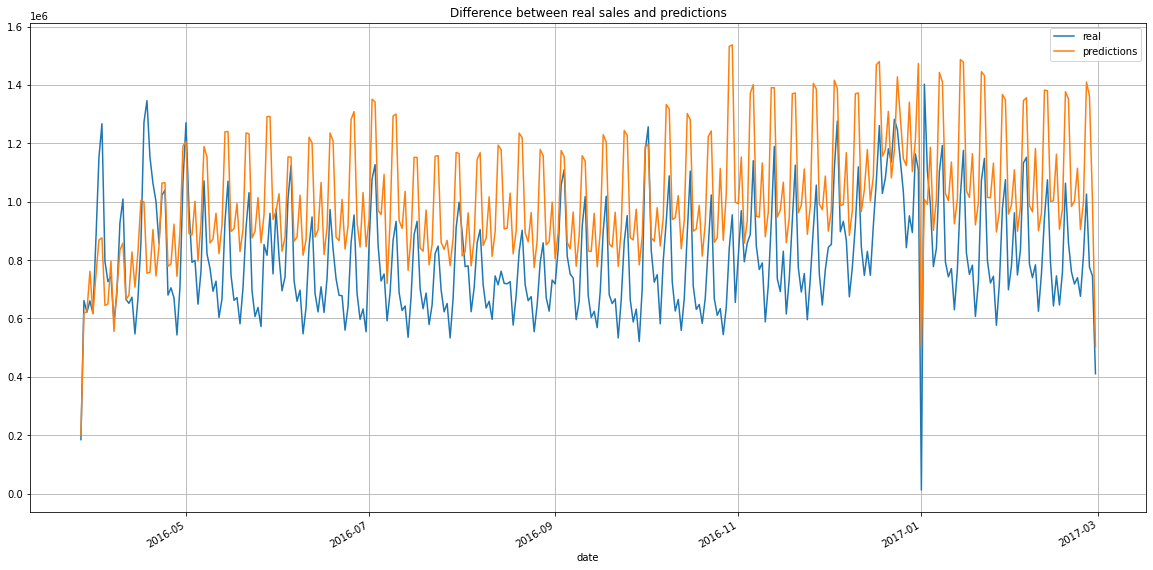

In [ ]:
sales_per_day = pred_df.groupby(by='date')['real', 'predictions'].sum()
sales_per_day = pd.DataFrame(data=sales_per_day)
sales_per_day.plot(figsize=(20,10), title='Difference between real sales and predictions', grid=True)

In [ ]:
to_predict_cp = add_datepart(to_predict, 'date')
to_predict_id = to_predict['id']
to_predict_cp.drop('id', axis=1, inplace=True)
to_predict_cp

,store_nbr,family,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,AUTOMOTIVE,0,2017,8,33,16,2,228,False,False,False,False,False,False,1.502842e+09
1,1,BABY CARE,0,2017,8,33,16,2,228,False,False,False,False,False,False,1.502842e+09
2,1,BEAUTY,2,2017,8,33,16,2,228,False,False,False,False,False,False,1.502842e+09
3,1,BEVERAGES,20,2017,8,33,16,2,228,False,False,False,False,False,False,1.502842e+09
4,1,BOOKS,0,2017,8,33,16,2,228,False,False,False,False,False,False,1.502842e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,POULTRY,1,2017,8,35,31,3,243,True,False,False,False,False,False,1.504138e+09
28508,9,PREPARED FOODS,0,2017,8,35,31,3,243,True,False,False,False,False,False,1.504138e+09
28509,9,PRODUCE,1,2017,8,35,31,3,243,True,False,False,False,False,False,1.504138e+09
28510,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,35,31,3,243,True,False,False,False,False,False,1.504138e+09


In [ ]:
to_predict_cp['encoded_family'] = family_encoder.transform(to_predict_cp[['family']])
to_predict_cp.drop('family', axis=1, inplace=True)
to_predict_final = pd.DataFrame(norm.transform(to_predict_cp), columns=to_predict_cp.columns)
to_predict_final

,store_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,0.000000,0.000000,1.333333,0.636364,0.615385,0.5,0.333333,0.623626,0.0,0.0,0.0,0.0,0.0,0.0,1.429297,0.00000
1,0.000000,0.000000,1.333333,0.636364,0.615385,0.5,0.333333,0.623626,0.0,0.0,0.0,0.0,0.0,0.0,1.429297,0.03125
2,0.000000,0.008511,1.333333,0.636364,0.615385,0.5,0.333333,0.623626,0.0,0.0,0.0,0.0,0.0,0.0,1.429297,0.06250
3,0.000000,0.085106,1.333333,0.636364,0.615385,0.5,0.333333,0.623626,0.0,0.0,0.0,0.0,0.0,0.0,1.429297,0.09375
4,0.000000,0.000000,1.333333,0.636364,0.615385,0.5,0.333333,0.623626,0.0,0.0,0.0,0.0,0.0,0.0,1.429297,0.12500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,0.150943,0.004255,1.333333,0.636364,0.653846,1.0,0.500000,0.664835,1.0,0.0,0.0,0.0,0.0,0.0,1.441998,0.87500
28508,0.150943,0.000000,1.333333,0.636364,0.653846,1.0,0.500000,0.664835,1.0,0.0,0.0,0.0,0.0,0.0,1.441998,0.90625
28509,0.150943,0.004255,1.333333,0.636364,0.653846,1.0,0.500000,0.664835,1.0,0.0,0.0,0.0,0.0,0.0,1.441998,0.93750
28510,0.150943,0.038298,1.333333,0.636364,0.653846,1.0,0.500000,0.664835,1.0,0.0,0.0,0.0,0.0,0.0,1.441998,0.96875


In [ ]:
pred = regressor.predict(to_predict_final)
pred[pred < 0] = 0

In [ ]:
to_submit = pd.DataFrame([to_predict_id, pred]).T
to_submit.columns = ['id', 'sales']
to_submit['id'] = to_submit['id'].astype('int')
to_submit.set_index('id', inplace=True)
to_submit

,sales
id,
3000888,125.674934
3000889,125.260292
3000890,839.875061
3000891,2785.183350
3000892,237.465179
...,...
3029395,398.820435
3029396,192.432007
3029397,838.827148


In [ ]:
to_submit.to_csv('first_attempt.csv')

In [ ]:
! kaggle competitions submit -c store-sales-time-series-forecasting -f first_attempt.csv -m "first attempt"

100% 715k/715k [00:03<00:00, 213kB/s]
Successfully submitted to Store Sales - Time Series Forecasting

### It seems a good idea to preprocess the stores data so then it can be use to add information to the other datasets.
To do this, I`m going to use Ordinal and OneHotEncoding with the help of the ColumnTransformer class from sklearn

In [ ]:
stores = pd.read_csv('/content/stores.csv')
print(stores.shape)
stores

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [ ]:
for i in ['city', 'state', 'type', 'cluster']:
  print(stores[i].value_counts(), end='\n\n')

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja            

In [ ]:
stores['location'] = stores['city'] + ', ' + stores['state']
locations = stores['location'].value_counts()
locations

Quito, Pichincha                                 18
Guayaquil, Guayas                                 8
Cuenca, Azuay                                     3
Santo Domingo, Santo Domingo de los Tsachilas     3
Manta, Manabi                                     2
Latacunga, Cotopaxi                               2
Machala, El Oro                                   2
Ambato, Tungurahua                                2
Quevedo, Los Rios                                 1
Esmeraldas, Esmeraldas                            1
Loja, Loja                                        1
Libertad, Guayas                                  1
Playas, Guayas                                    1
Daule, Guayas                                     1
Babahoyo, Los Rios                                1
Salinas, Santa Elena                              1
Puyo, Pastaza                                     1
Guaranda, Bolivar                                 1
Ibarra, Imbabura                                  1
Riobamba, Ch

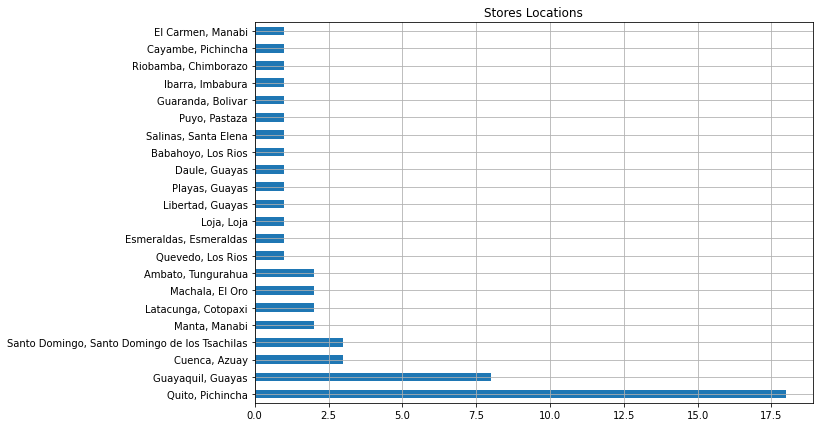

In [ ]:
locations.plot(kind='barh', figsize=(10, 7), grid=True, title='Stores Locations')

In [ ]:
stores.drop(['city', 'state'], axis=1, inplace=True)
boolean_freq = stores.location.value_counts() <= 2
less_freq = stores['location'].value_counts()[boolean_freq].index
stores.loc[stores['location'].isin(less_freq), 'location'] = 'Less Frequent'
stores.location.value_counts()

Less Frequent                                    22
Quito, Pichincha                                 18
Guayaquil, Guayas                                 8
Santo Domingo, Santo Domingo de los Tsachilas     3
Cuenca, Azuay                                     3
Name: location, dtype: int64

In [ ]:
stores.head()

,store_nbr,type,cluster,location
0,1,D,13,"Quito, Pichincha"
1,2,D,13,"Quito, Pichincha"
2,3,D,8,"Quito, Pichincha"
3,4,D,9,"Quito, Pichincha"
4,5,D,4,"Santo Domingo, Santo Domingo de los Tsachilas"


In [ ]:
# Encoding the stores dataset

oh_cols = ['type', 'location']

store_transf = ColumnTransformer(
                  transformers=[
                      ('ordinal', OrdinalEncoder(), ['cluster']),
                      ('one_hot', OneHotEncoder(), oh_cols)
                  ])

stores_proc = store_transf.fit_transform(stores)

oh_cols = store_transf.named_transformers_['one_hot'].get_feature_names_out()
cols_names = list(chain(['cluster'], oh_cols))
stores_proc = pd.DataFrame(stores_proc.toarray(), 
                           columns=cols_names)
stores_proc['store_nbr'] = stores['store_nbr']
stores_proc

,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",location_Less Frequent,"location_Quito, Pichincha","location_Santo Domingo, Santo Domingo de los Tsachilas",store_nbr
0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
2,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3
3,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5
5,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6
6,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7
7,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8
8,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9
9,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10


In [ ]:
train_w_store = pd.merge(train_ds, stores_proc, on='store_nbr', how='left')
valid_w_store = pd.merge(train_ds, stores_proc, on='store_nbr', how='left')
train_w_store

,id,date,store_nbr,family,sales,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",location_Less Frequent,"location_Quito, Pichincha","location_Santo Domingo, Santo Domingo de los Tsachilas"
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,2100617,2016-03-27,49,BEAUTY,10.000,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2100618,2100618,2016-03-27,49,BEVERAGES,8885.000,4,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2100619,2100619,2016-03-27,49,BOOKS,0.000,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2100620,2100620,2016-03-27,49,BREAD/BAKERY,1374.956,2,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train, y_train = add_date_and_drop(train_w_store, indep=True)
X_valid, y_valid = add_date_and_drop(valid_w_store, indep=True)
X_train

,store_nbr,family,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay",...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,AUTOMOTIVE,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,False,True,False,True,False,True,1.356998e+09
1,1,BABY CARE,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,False,True,False,True,False,True,1.356998e+09
2,1,BEAUTY,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,False,True,False,True,False,True,1.356998e+09
3,1,BEVERAGES,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,False,True,False,True,False,True,1.356998e+09
4,1,BOOKS,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,False,True,False,True,False,True,1.356998e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,49,BEAUTY,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27,6,87,False,False,False,False,False,False,1.459037e+09
2100618,49,BEVERAGES,4,10.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27,6,87,False,False,False,False,False,False,1.459037e+09
2100619,49,BOOKS,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27,6,87,False,False,False,False,False,False,1.459037e+09
2100620,49,BREAD/BAKERY,2,10.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27,6,87,False,False,False,False,False,False,1.459037e+09


In [ ]:
family_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['encoded_family'] = family_encoder.fit_transform(X_train[['family']])
X_train.drop('family', axis=1, inplace=True)
X_train

,store_nbr,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,0.0
1,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,1.0
2,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,2.0
3,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,3.0
4,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,49,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,2.0
2100618,49,4,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,3.0
2100619,49,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,4.0
2100620,49,2,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,5.0


In [ ]:
X_valid['encoded_family'] = family_encoder.transform(X_valid[['family']])
X_valid.drop('family', axis=1, inplace=True)
X_valid

,store_nbr,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,0.0
1,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,1.0
2,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,2.0
3,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,3.0
4,1,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,False,True,False,True,False,True,1.356998e+09,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,49,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,2.0
2100618,49,4,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,3.0
2100619,49,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,4.0
2100620,49,2,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,87,False,False,False,False,False,False,1.459037e+09,5.0


In [ ]:
norm = MinMaxScaler()
X_train_final = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_train_final

,store_nbr,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.00000
1,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.03125
2,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.06250
3,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.09375
4,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.12500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,0.90566,0.000000,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.06250
2100618,0.90566,0.017021,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.09375
2100619,0.90566,0.000000,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.12500
2100620,0.90566,0.008511,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.15625


In [ ]:
X_valid_final = pd.DataFrame(norm.transform(X_valid), columns=X_valid.columns)
X_valid_final

,store_nbr,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,encoded_family
0,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.00000
1,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.03125
2,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.06250
3,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.09375
4,0.00000,0.000000,0.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.12500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100617,0.90566,0.000000,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.06250
2100618,0.90566,0.017021,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.09375
2100619,0.90566,0.000000,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.12500
2100620,0.90566,0.008511,0.625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.236264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.15625


In [ ]:
regressor = XGBRegressor(n_jobs=-1, n_estimators=100)
regressor.fit(X_train_final, y_train)
yhat = regressor.predict(X_valid_final)
yhat[yhat < 0] = 0
score = mean_squared_log_error(y_valid, yhat, squared=False)
score

[12:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2.6067456936995748

In [ ]:
to_pred_w_store = pd.merge(to_predict, stores_proc, on='store_nbr', how='left')
to_pred_pp, to_pred_ids = add_date_and_drop(to_pred_w_store, indep=)
to_pred_pp['encoded_family'] = family_encoder.transform(to_pred_pp[['family']])
to_pred_pp.drop('family', axis=1, inplace=True)
to_pred_final = pd.DataFrame(norm.transform(to_pred_pp), columns=to_pred_pp.columns)
to_pred_final

Preprocessing Holidays Dataset

In [ ]:
for i in holidays.columns:
  print(holidays[i].value_counts(dropna=False), end='\n\n')

2014-06-25    4
2017-06-25    3
2016-06-25    3
2015-06-25    3
2013-06-25    3
             ..
2014-07-13    1
2014-07-12    1
2014-07-09    1
2014-07-08    1
2017-12-26    1
Name: date, Length: 312, dtype: int64

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

National    174
Local       152
Regional     24
Name: locale, dtype: int64

Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmer

Real holidays are those that have transfered = False, so we are going to drop the transfered = True holidays

In [ ]:
transferred = holidays['transferred'] == False
real_holidays = holidays.loc[transferred]
real_holidays.transferred.value_counts()

False    338
Name: transferred, dtype: int64

In [ ]:
holidays.description.unique()

array(['Fundacion de Manta', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Cantonizacion de Riobamba', 'Cantonizacion del Puyo',
       'Cantonizacion de Guaranda', 'Provincializacion de Imbabura',
       'Cantonizacion de Latacunga', 'Fundacion de Machala',
       'Fundacion de Santo Domingo', 'Cantonizacion de El Carmen',
       'Cantonizacion de Cayambe', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Independencia de Guayaquil',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fundacion de Quito-1', 'Fundacion de Quito', 'Fundacion de Loja',
       'Navidad-4', 'Cantonizac

Including the earthquake in the information that feeds the model could be a mistake, because we can`t have that information before it happens, so its not goign to be available when predicting.

In [ ]:
without_earthq = real_holidays.loc[~holidays['description'].str.contains('Terremoto'), :]
without_earthq.reset_index(inplace=True)

Checking cardinality of columns in holiday dataset

In [ ]:
for i in without_earthq.columns:
  print(i, len(without_earthq[i].unique()))

index 307
date 274
type 6
locale 3
locale_name 24
description 72
transferred 1


Dropping columns with high cardinality and/or that may be not usefull to the model

In [ ]:
without_earthq = without_earthq.drop(['locale_name', 'description', 'transferred'], axis=1)

Creating a dataframe with the columns to encode, leaving out the date column

In [ ]:
to_encode = without_earthq[['type', 'locale']]
to_encode

,type,locale
0,Holiday,Local
1,Holiday,Regional
2,Holiday,Local
3,Holiday,Local
4,Holiday,Local
...,...,...
302,Additional,National
303,Additional,National
304,Additional,National
305,Holiday,National


Encoding with OneHotEncoder

In [ ]:
oh_encoder_holiday = OneHotEncoder()

encoded_holidays = oh_encoder_holiday.fit_transform(to_encode)
cols = oh_encoder_holiday.get_feature_names_out()

cols_names = [f'holiday_{i}' for i in cols]

holidays_final = pd.DataFrame(encoded_holidays.toarray(), columns=cols_names)

holidays_final

,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,holiday_locale_Local,holiday_locale_National,holiday_locale_Regional
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
302,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
303,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
304,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
without_earthq['date']

0      2012-03-02
1      2012-04-01
2      2012-04-12
3      2012-04-14
4      2012-04-21
          ...    
302    2017-12-22
303    2017-12-23
304    2017-12-24
305    2017-12-25
306    2017-12-26
Name: date, Length: 307, dtype: object

In [ ]:
holidays_final['date'] = pd.to_datetime(without_earthq['date'])
holidays_final.drop_duplicates(['date'], keep='first', inplace=True)
holidays_final

,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,holiday_locale_Local,holiday_locale_National,holiday_locale_Regional,date
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012-03-02
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2012-04-01
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012-04-12
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012-04-14
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012-04-21
...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2017-12-22
303,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2017-12-23
304,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2017-12-24
305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2017-12-25


#### Oil Dataset Preprocessing

In [ ]:
oil['date'] = pd.to_datetime(oil['date'])

In [ ]:
oil.dcoilwtico.value_counts(dropna=False)

NaN      43
96.44     4
46.02     4
47.72     4
60.01     4
         ..
95.54     1
94.35     1
96.40     1
93.97     1
47.26     1
Name: dcoilwtico, Length: 999, dtype: int64

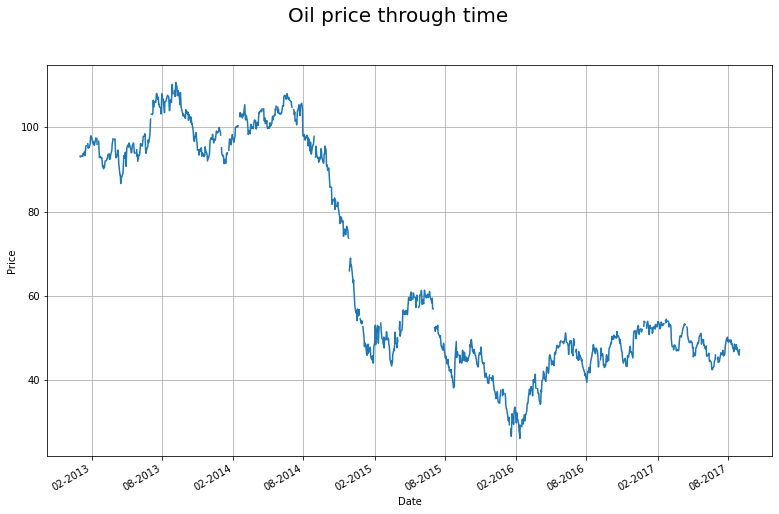

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(13, 8))

half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%m-%Y") # four digits for year, two for month

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.plot(oil.date, oil.dcoilwtico)
fig.suptitle('Oil price through time', fontsize=20)
fig.autofmt_xdate()

As seen on the graph, there are some gaps in the historical information about the oil price that need to be filled.
To do this, I`m going to interpolate the values, i.e. to replace the missing values with the mean between the previous and next values.

In [ ]:
fill_na_oil = oil.copy()
fill_na_oil['oil_price'] = fill_na_oil['dcoilwtico'].interpolate()
fill_na_oil = fill_na_oil.iloc[1: , :]
fill_na_oil.drop(['dcoilwtico'], axis=1, inplace=True)
fill_na_oil

,date,oil_price
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


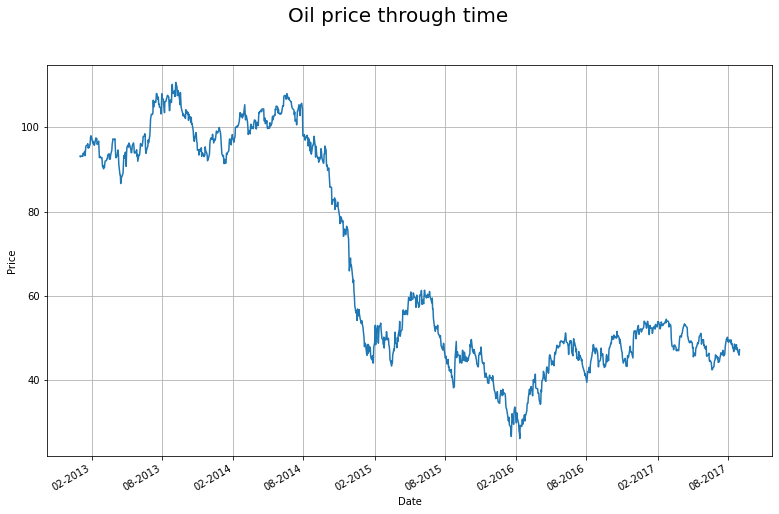

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))

half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%m-%Y") # four digits for year, two for month

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.plot(fill_na_oil.date, fill_na_oil.oil_price)
fig.suptitle('Oil price through time', fontsize=20)
fig.autofmt_xdate()

### Now its time to join the datasets to have a unique source of information

In [ ]:
train_v2 = pd.merge(train, stores_proc, on='store_nbr', how='left')
train_v2

,id,date,store_nbr,family,sales,onpromotion,cluster,type_A,type_B,type_C,type_D,type_E,"location_Cuenca, Azuay","location_Guayaquil, Guayas",location_Less Frequent,"location_Quito, Pichincha","location_Santo Domingo, Santo Domingo de los Tsachilas"
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_v2.isna().sum() / len(train.index)

id                                                        0.0
date                                                      0.0
store_nbr                                                 0.0
family                                                    0.0
sales                                                     0.0
onpromotion                                               0.0
cluster                                                   0.0
type_A                                                    0.0
type_B                                                    0.0
type_C                                                    0.0
type_D                                                    0.0
type_E                                                    0.0
location_Cuenca, Azuay                                    0.0
location_Guayaquil, Guayas                                0.0
location_Less Frequent                                    0.0
location_Quito, Pichincha                                 0.0
location

In [ ]:
train['date'] = pd.to_datetime(train['date'])

In [ ]:
train_v3 = pd.merge(train, fill_na_oil, on='date', how='left')

In [ ]:
train_v3['oil_price'].value_counts(dropna=False)

NaN      858924
46.02      7128
93.12      7128
60.01      7128
47.72      7128
          ...  
76.52      1782
75.74      1782
74.04      1782
73.70      1782
47.57      1782
Name: oil_price, Length: 1030, dtype: int64

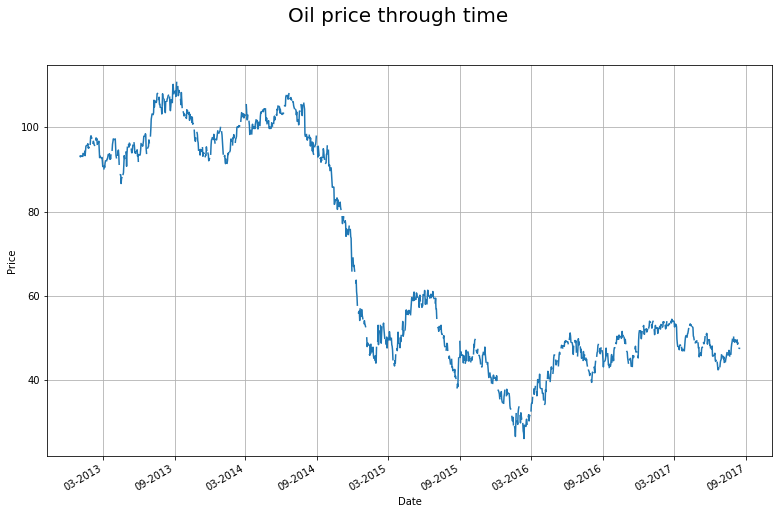

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))

half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%m-%Y") # four digits for year, two for month

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.plot(train_v3.date, train_v3.oil_price)
fig.suptitle('Oil price through time', fontsize=20)
fig.autofmt_xdate()